<img src="https://github.com/danielscarvalho/data/blob/master/img/FIAP-logo.png?raw=True" style="float:right;" width="200px">

# DATA SCIENCE & STATISTICAL COMPUTING [》](https://www.fiap.com.br/)

## FIAP - Engenharia de Software

### Global Solution (GS) 2 - 2024 - 2 Semestre

### Desenvolvedores:
- Lucas Moreno  - RM 97158
- Julia Ortiz   - RM 550204
- Juliana Maita - RM 99224

### Resumo

Este projeto visa analisar a pegada de carbono global e comparar as emissões do Brasil
com os principais emissores globais e regionais, como EUA, OCDE e o continente
americano. A análise inclui a visualização de padrões de emissões por setores econômicos
e a modelagem preditiva utilizando algoritmos de aprendizado de máquina (ML) para prever
tendências futuras até 2025.<br>
O projeto utiliza bibliotecas como Pandas, Seaborn e Scikitlearn, além de dados obtidos do CarbonMonitor.

### Execução
- Foram utilizados dois datasets adquiridos via **API** do [Carbonmonitor](https://carbonmonitor.org/), sobre Emissões de CO2 separadas por Países e seus Setores, e Produção de Energia separada por Países e suas diversas Fontes de energia.
- Foi feito o uso compreensivo de LLMs e Copilot para elaboração rápida de código com Pandas, Matplotlib, Seaborn e Scikit-Learn

### Introdução
A pegada de carbono mede a emissão de gases de efeito estufa (GEE) de uma nação,
abrangendo setores como energia, transporte, agricultura e indústria.<br>
Este projeto busca responder perguntas como:
- Como o Brasil se posiciona em relação às emissões globais?
- Quais setores mais contribuem para as emissões no Brasil e em outros países?
- Como as tendências de emissões mudaram ao longo dos anos?

### Objetivos
1. Comparar as emissões de CO₂ do Brasil com:
    - O total Global.
    - Países da OCDE.
    - Estados Unidos e continente americano.
2. Identificar os principais setores emissores no Brasil e globalmente.
3. Prever as emissões de CO₂ do Brasil até 2025 utilizando algoritmos de aprendizado
de máquina.


### Referências

- Pandas - https://pandas.pydata.org/docs/
- Jupyter - https://docs.jupyter.org/en/latest/
- Seaborn - https://seaborn.pydata.org/
- NumPy - https://numpy.org/
- SciPy - https://scipy.org/
- Scikit-learn - https://scikit-learn.org/stable/ (ML, AI)
- Estatística - https://www.statlearning.com/
- Data Science - https://jakevdp.github.io/PythonDataScienceHandbook/
- Matplotlib - https://matplotlib.org/
- HoloViews - https://holoviews.org/
- Python - https://penseallen.github.io/PensePython2e/
- Python Fluente - https://pythonfluente.com/
- Git - https://git-scm.com/doc
- Kaggle - https://www.kaggle.com/


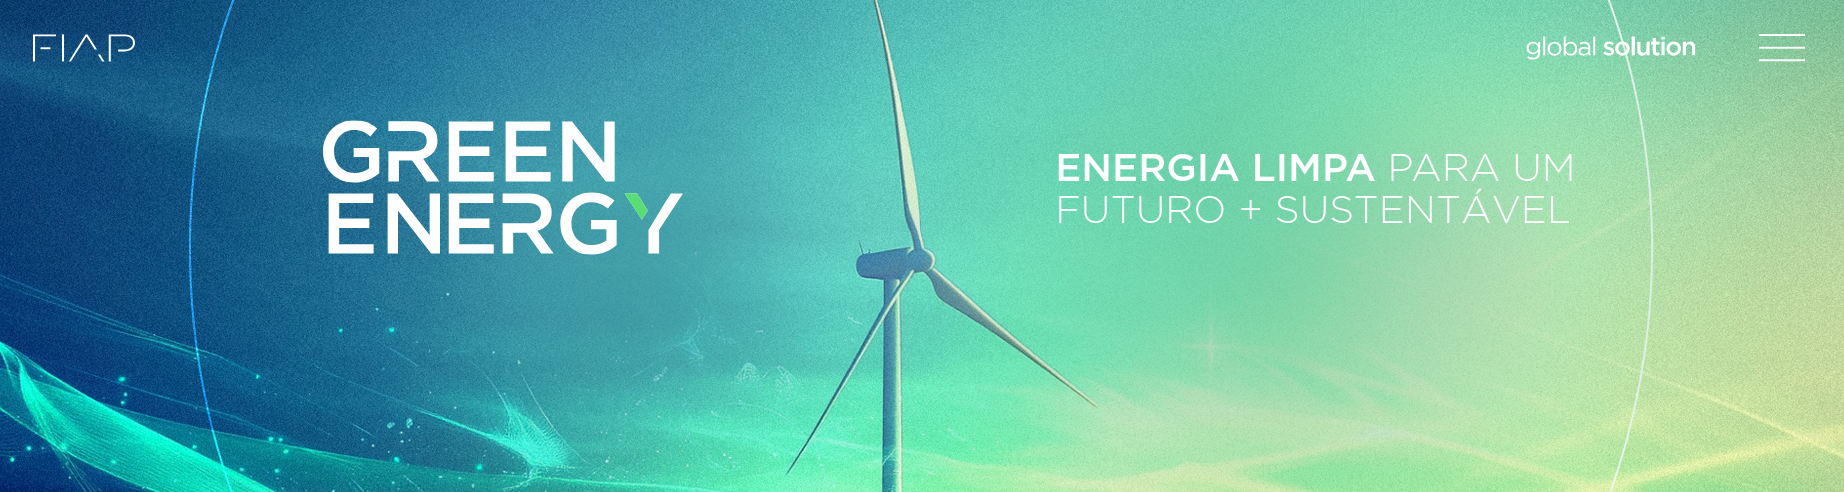

## Perguntas

### 0. Importando e Tratando

In [1]:
import json
import os
from typing import List, cast

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

- Definindo uma função para baixar e cachear os Datasets de https://carbonmonitor.org/

In [2]:
def baixar_carbonmonitor_com_cache(url, cache_file, *args, **kwargs):
    # Tentar ler uma resposta cacheada primeiro
    if os.path.exists(cache_file):
        with open(cache_file, "r") as file:
            print(f"Procurando resposta cacheada no arquivo '{cache_file}'...")
            data = json.load(file)

        # Checando se a resposta cacheada está dentro do período de cache
        idade_resposta = pd.Timestamp.now() - pd.to_datetime(data["__request_date"])
        if idade_resposta < pd.Timedelta(days=1):
            # Cache válido.
            print("Resposta cacheda encontrada.")
            return data["datas"]
        else:
            # Cache inválido.
            # Remover o arquivo antigo de cache, e deixar o resto da função baixar nova resposta...
            print("Resposta cacheada velha demais. Descartando...")
            os.remove(cache_file)

    # Se o cache não estava presente, ou se era inválido...
    print("Baixando dados da API...")
    response = requests.get(url, headers={
        "Host": "datas.carbonmonitor.org",
        "Origin": "https://carbonmonitor.org",
        "Referer": "https://carbonmonitor.org/",
    }, *args, **kwargs)

    # Dar um erro se a resposta do servidor foi inválida
    response.raise_for_status()
    data = response.json()

    # Salvando timestamp atual no arquivo da resposta
    data["__request_date"] = pd.Timestamp.now().isoformat()

    # Salvando a resposta para o arquivo
    with open(cache_file, "w") as file:
        json.dump(data, file)
    print(f"Resposta cacheada no arquivo '{cache_file}'.")
    
    return data["datas"]

#### dfDailyEmissionsPerSector
- Baixando e tratando o Dataset de Emissões de CO2 do Carbonmonitor

In [3]:
# URL do GET request
url = "https://datas.carbonmonitor.org/API/carbon_global/WORLD;China;United%20States;India;EU27%20&%20UK;United%20Kingdom;France;Germany;Italy;Spain;Russia;Japan;Brazil;ROW"

# Caminho do arquivo de cache
cache_file = "carbon_data_cache.json"

# Baixar dados
carbon_data = baixar_carbonmonitor_com_cache(url, cache_file)

# Criando dataframe com os dados importados
dfDailyEmissionsPerSector = (
    pd.DataFrame(carbon_data, columns=["Country", "Date", "Sector", "MtCO2", "Timestamp"])

    # Descartando a coluna Timestamp pois não será necessária
    .drop(columns="Timestamp")

    # Convertendo as colunas Date e MtCO2 para Datetime e Float
    .assign(
        Date = lambda df: pd.to_datetime(df["Date"], format="%d/%m/%Y"),
        MtCO2 = lambda df: pd.to_numeric(df["MtCO2"]) 
        )
    )

# Limpando variáveis
del url, cache_file, carbon_data

dfDailyEmissionsPerSector

Procurando resposta cacheada no arquivo 'carbon_data_cache.json'...
Resposta cacheda encontrada.


Country       Date                  Sector      MtCO2
0       Brazil 2019-01-01       Domestic Aviation   0.023750
1       Brazil 2019-01-01        Ground Transport   0.201663
2       Brazil 2019-01-01                Industry   0.240156
3       Brazil 2019-01-01  International Aviation   0.018398
4       Brazil 2019-01-01                   Power   0.107727
...        ...        ...                     ...        ...
176395   WORLD 2024-09-30        Ground Transport  19.475600
176396   WORLD 2024-09-30                Industry  30.013200
176397   WORLD 2024-09-30  International Aviation   1.831910
176398   WORLD 2024-09-30                   Power  36.848200
176399   WORLD 2024-09-30             Residential   6.363760

[176400 rows x 4 columns]

#### dfDailyEmissionsAggregate
Fazendo um dataframe secundário para segurar os valores agregados entre todos os Setores

In [4]:
dfDailyEmissionsAggregate = dfDailyEmissionsPerSector.groupby(["Country", "Date"])["MtCO2"].sum().reset_index()
dfDailyEmissionsAggregate

Country       Date      MtCO2
0      Brazil 2019-01-01   0.690146
1      Brazil 2019-01-02   0.903277
2      Brazil 2019-01-03   0.966163
3      Brazil 2019-01-04   0.951562
4      Brazil 2019-01-05   0.905974
...       ...        ...        ...
29395   WORLD 2024-09-26  98.824990
29396   WORLD 2024-09-27  96.379110
29397   WORLD 2024-09-28  93.193950
29398   WORLD 2024-09-29  89.392350
29399   WORLD 2024-09-30  95.533770

[29400 rows x 3 columns]

#### dfDailyPowerPerSector
- Baixando e tratando o Dataset de Fontes de Energia do Carbonmonitor

In [5]:
# URL do GET request
url = "https://datas.carbonmonitor.org/API/energy_global/China;India;United%20States;EU27%20&%20UK;United%20Kingdom;France;Germany;Italy;Spain;Russia;Japan;Brazil;Australia;South%20Africa;Chile;Mexico;Turkey"

# Caminho do arquivo de cache
cache_file = "power_data_cache.json"

# Baixar dados
power_data = baixar_carbonmonitor_com_cache(url, cache_file)

# Criando dataframe com os dados importados
dfDailyPowerPerSector = (
    pd.DataFrame(power_data, columns=["Country", "Date", "Type", "GWh/d", "Timestamp"])

    # Descartando a coluna Timestamp pois não será necessária
    .drop(columns="Timestamp")

    # Convertendo as colunas Date e MtCO2 para Datetime e Float
    .assign(**{
        "Date": lambda df: pd.to_datetime(df["Date"], format="%d/%m/%Y"),
        "GWh/d": lambda df: pd.to_numeric(df["GWh/d"]) 
        })
    )

# Limpando variáveis
del url, cache_file, power_data

dfDailyPowerPerSector

Procurando resposta cacheada no arquivo 'power_data_cache.json'...
Resposta cacheda encontrada.


Country       Date  Type     GWh/d
0           Australia 2019-01-01  Coal   437.583
1           Australia 2019-01-02  Coal   444.169
2           Australia 2019-01-03  Coal   447.511
3           Australia 2019-01-04  Coal   447.332
4           Australia 2019-01-05  Coal   444.023
...               ...        ...   ...       ...
292379  United States 2024-11-18  Wind  1389.130
292380  United States 2024-11-19  Wind  1491.390
292381  United States 2024-11-20  Wind  1481.720
292382  United States 2024-11-21  Wind  1480.170
292383  United States 2024-11-22  Wind  1483.520

[292384 rows x 4 columns]

### 1. Visualizando histórico de emissões de Toneladas Métricas de CO2 por país

- Usando dados agregados entre todos os Setores de cada País
- Descartando dados do mundo inteiro agregado
- Fazendo média móvel das emissões de cada país por 7 dias para melhorar a legibilidade do gráfico

In [6]:
dfQ1 = (dfDailyEmissionsAggregate
    # Descartando dados do mundo inteiro agregado
    [~dfDailyEmissionsAggregate["Country"].isin(["WORLD"])]

    # Fazendo média móvel das emissões de cada país por 7 dias para melhorar a legibilidade do gráfico
    .assign(rollingMtCO2 = lambda x:
        cast(pd.DataFrame, x) # Essa linha existe puramente para fazer o typing do IntelliSense funcionar
        .groupby("Country", as_index=False)["MtCO2"].rolling(7, min_periods=1).mean()["MtCO2"]
    )
)
dfQ1

Country       Date      MtCO2  rollingMtCO2
0             Brazil 2019-01-01   0.690146      0.690146
1             Brazil 2019-01-02   0.903277      0.796712
2             Brazil 2019-01-03   0.966163      0.853195
3             Brazil 2019-01-04   0.951562      0.877787
4             Brazil 2019-01-05   0.905974      0.883424
...              ...        ...        ...           ...
27295  United States 2024-09-26  14.325019     14.143610
27296  United States 2024-09-27  14.110585     14.068329
27297  United States 2024-09-28  13.206505     13.942849
27298  United States 2024-09-29  12.190760     13.855953
27299  United States 2024-09-30  13.165790     13.779876

[27300 rows x 4 columns]

#### Figura
- Mostrando gráfico de linhas para comparação de Emissões Totais entre Países

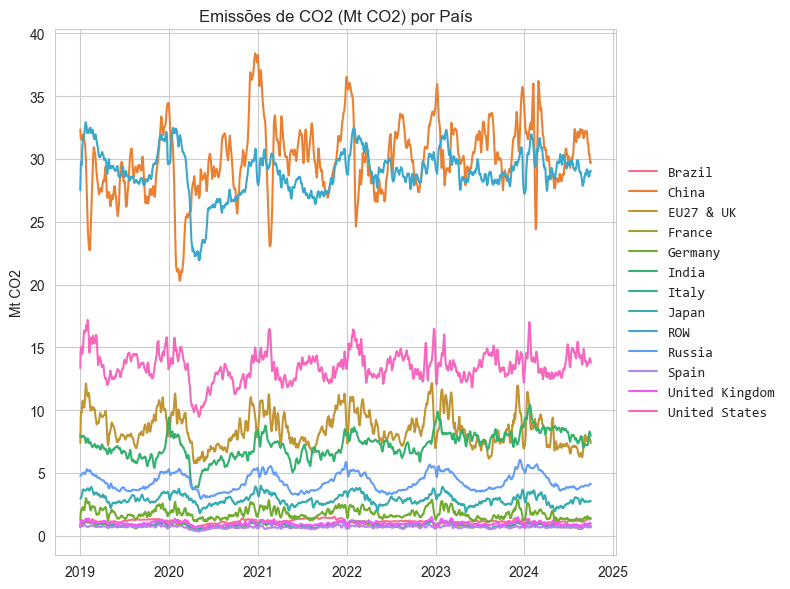

In [7]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.lineplot(
    data=dfQ1,
    y="rollingMtCO2",
    x="Date",
    hue="Country",
)

# Posicionando e customizando a legenda do gráfico
sns.move_legend(
    ax,
    "center left",
    bbox_to_anchor=(1, 0.5), # verticalmente no meio; para a direita do gráfico
    title=None,
    frameon=False,
    prop={"family": "consolas"}
)

plt.title("Emissões de CO2 (Mt CO2) por País")
plt.xlabel("")
plt.ylabel("Mt CO2")
plt.tight_layout()
plt.show()

### 2. Médias Móveis e Visibilidade nos gráficos
Visualizando diferenças entre Médias Móveis para melhorar a legibilidade dos Gráficos de linha

- Definindo funções para auxiliar na renderização da figura

In [8]:
def Q2_processarMediaMovel(df: pd.DataFrame, janela=0):
    return (
        df
        .groupby(["Country", "Sector"], as_index=False)
        ["MtCO2"]
        .rolling(janela, min_periods=1)
        .mean()
        ["MtCO2"]
    )

def Q2_renderizarChart(df: pd.DataFrame, ax: plt.Axes, title: str, janela: int):
    if janela > 1:
        df = df.assign(MtCO2=Q2_processarMediaMovel(df, janela))
    g = sns.lineplot(
        data = df,
        y="MtCO2",
        x="Date",
        hue="Sector",
        legend="full",
        ax=ax,
    )
    ax.set_title(title)
    # Escondendo os labels e ticks, os valores não são importantes aqui, somente a visibilidade das linhas
    ax.set_xlabel(''), ax.set_xlim(df["Date"].min())
    ax.set_ylabel(''), ax.set_ylim(0), ax.set_yticks([])
    return g

- Selecionando dados somente sobre o Brasil

In [9]:
dfQ2 = dfDailyEmissionsPerSector.groupby("Country").get_group("Brazil")

#### Figura
- Mostrando múltiplos gráficos de linhas, variando o tamanho da janela da média móvel.

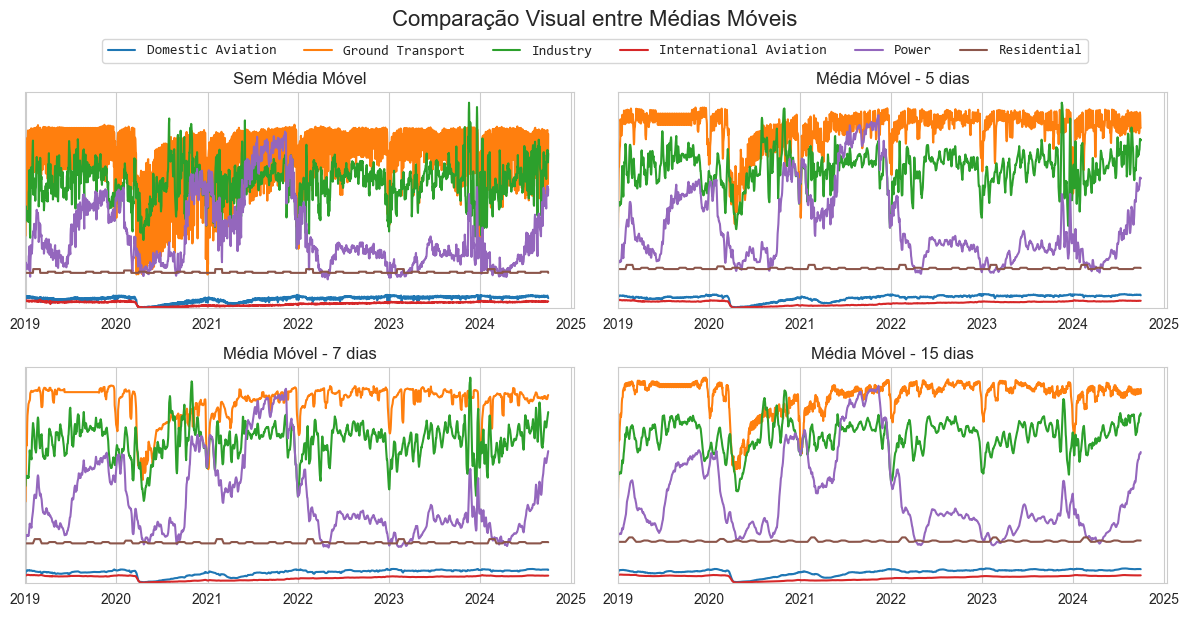

In [10]:
# Fazendo uma figura com subplots em 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes: List[List[plt.Axes]] # Explicitando o Type de `axes` para fazer o IntelliSense funcionar corretamente :/

# Plot 1 - Sem Média Móvel
Q2_renderizarChart(dfQ2, axes[0][0], "Sem Média Móvel", 0)
# Plot 2 - 5 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[0][1], "Média Móvel - 5 dias", 5)
# Plot 3 - 7 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[1][0], "Média Móvel - 7 dias", 7)
# Plot 4 - 15 Dias de Média Móvel
Q2_renderizarChart(dfQ2, axes[1][1], "Média Móvel - 15 dias", 15)

# Extraindo as handles e labels da legenda gerados pelo Seaborn
handles, labels = axes[0][0].get_legend_handles_labels()

# Removendo as legendas de todos os sub-plots, elas só serviam para fazer o passo acima :)
for ax in axes.flat:
    ax.legend_.remove()

# Manualmente renderizando uma legenda nova no topo da figura inteira
fig.legend(
    handles, labels, loc="lower center", bbox_to_anchor=(0.5, 0.92), ncol=6, frameon=True, prop={"family": "consolas"}
)

plt.suptitle("Comparação Visual entre Médias Móveis", 
               x=0.5, y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Limpando variáveis
del fig, axes, handles, labels, ax

- Entre a Média de 5 para a Média de 7, a linha de "Ground Transport" é dramaticamente suavizada, sugerindo que há variação nas emissões deste setor, seguindo um período de 7 dias
- A Média Móvel de 7 dias parece ter a melhor troca entre legibilidade e perda de dados
- Bonus: Se sobrar tempo, considerar fazer isso também: https://seaborn.pydata.org/examples/timeseries_facets.html

### 3. Evolução de Emissões por País e Setor
Visualizando histórico de Emissões por Setor em <u>escala normalizada</u>, para comparação relativa entre tendências e picos

- Selecionando somente 4 países para comparação lado a lado
- Fazendo média móvel por 30 dias das emissões de cada setor para melhorar a legibilidade dos gráficos

In [11]:
Q3_usarPaises = [
    "Brazil",  "United States",
    "France",  "China",
]

dfQ3 = (dfDailyEmissionsPerSector
    # Filtrando somente países selecionados
    [dfDailyEmissionsPerSector["Country"].isin(Q3_usarPaises)]

    # Fazendo média móvel por 30 dias das emissões de cada setor para melhorar a legibilidade do gráfico
    .assign(rollingMtCO2 = dfDailyEmissionsPerSector
            .groupby(["Country", "Sector"], as_index=False)["MtCO2"].rolling(30, min_periods=1).mean()["MtCO2"]
    )
)
dfQ3

Country       Date                  Sector     MtCO2  \
0              Brazil 2019-01-01       Domestic Aviation  0.023750   
1              Brazil 2019-01-01        Ground Transport  0.201663   
2              Brazil 2019-01-01                Industry  0.240156   
3              Brazil 2019-01-01  International Aviation  0.018398   
4              Brazil 2019-01-01                   Power  0.107727   
...               ...        ...                     ...       ...   
176389  United States 2024-09-30        Ground Transport  4.716510   
176390  United States 2024-09-30                Industry  2.577250   
176391  United States 2024-09-30  International Aviation  0.203197   
176392  United States 2024-09-30                   Power  4.271040   
176393  United States 2024-09-30             Residential  0.962485   

        rollingMtCO2  
0           0.023750  
1           0.201663  
2           0.240156  
3           0.018398  
4           0.107727  
...              ...  
176389      4.553647  
176390      2.856086  
176391      0.209775  
176392      4.733138  
176393      0.951353  

[50400 rows x 5 columns]

#### Figura
- Mostrando gráficos de linhas com Emissões de cada Setor, entre os 4 países selecionados
- Obs: Note que cada gráfico está em escalas diferentes para melhor visualizar e comparar as variações de cada país

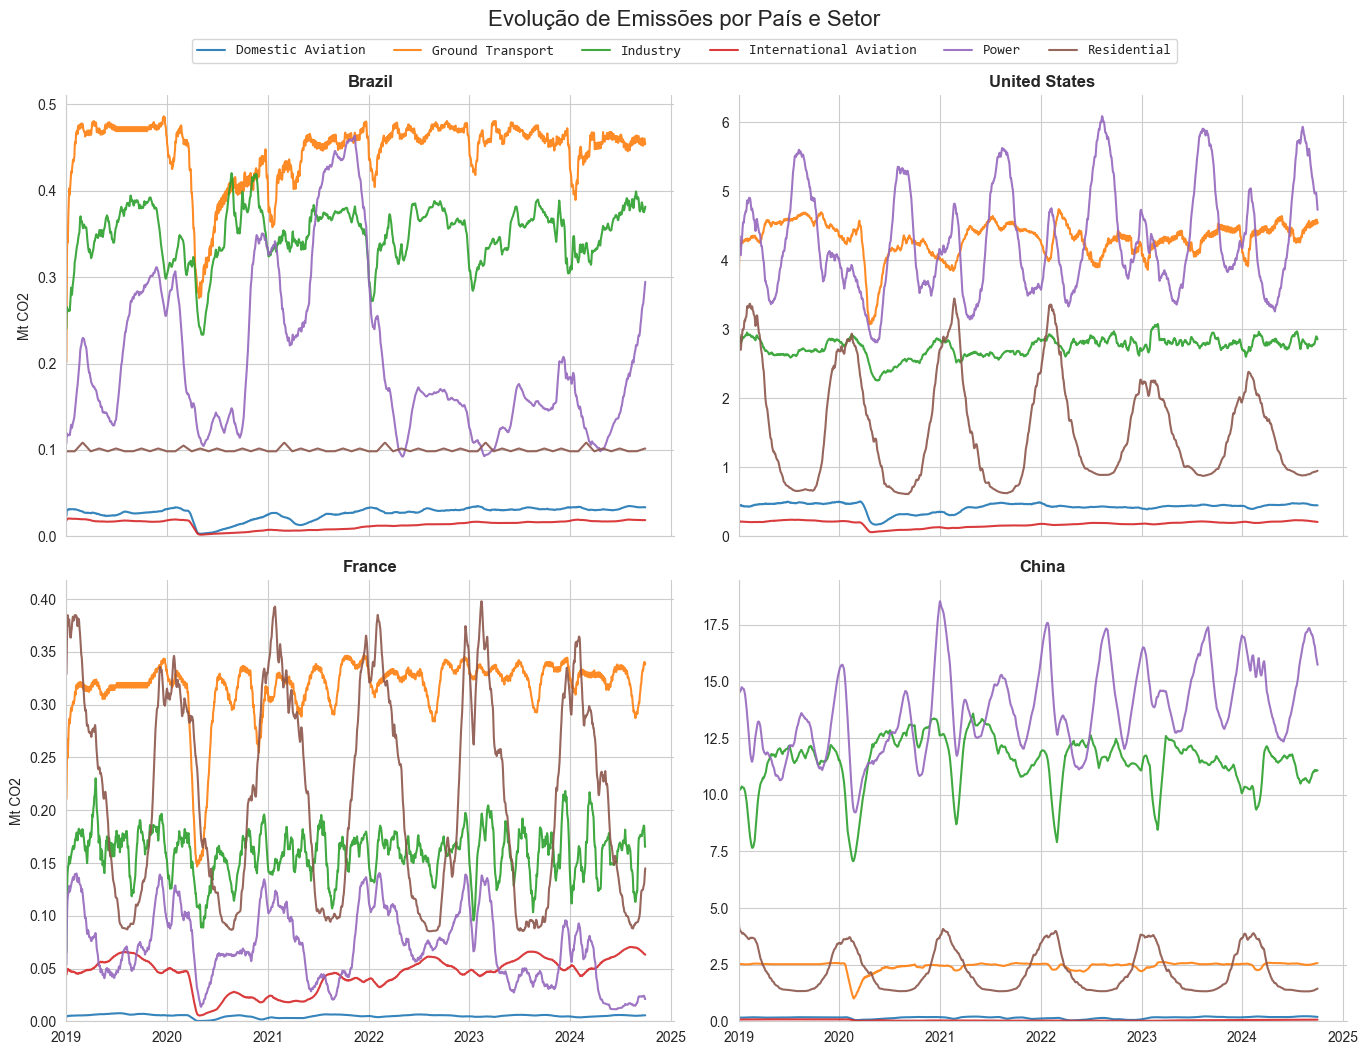

In [12]:
sns.set_style("whitegrid")
g = sns.relplot(
    kind="line",
    data=dfQ3,
    x="Date",
    y="rollingMtCO2", # Experimente mudar esse valor para "MtCO2" e veja como os gráficos ficam ilegíveis sem a média móvel :)
    col="Country",
    hue="Sector",
    alpha=0.9,
    facet_kws={
        "sharey": False,
    },
    col_wrap=2,
    col_order=Q3_usarPaises,
    aspect=1.2,
)

# Colocando legenda no topo da figura
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.99),
    ncol=6, title=None, frameon=True,
    prop={"family": "consolas"}
)

for pais, ax in g.axes_dict.items():
    ax.set_title(pais, fontdict={"fontweight":"bold"})
    ax.set_xlim(dfQ3["Date"].min())
    ax.set_ylim(0)

g.set_axis_labels("", "Mt CO2")

g.figure.tight_layout()
g.figure.suptitle("Evolução de Emissões por País e Setor", 
               x=0.5, y=1.05, fontsize=16)

plt.show()
# Limpando variáveis
del g, pais, ax

- Para todos os países, há uma notável queda nos setores de transporte durante 2020, provavelmente devido à pandemia
- O setor residencial da França e Estados Unidos sobe muito durante o inverno, o da China sobe menos, e o do Brasil está praticamente imóvel.
    - Será que é porque não usamos ar condicionado/aquecedores em casa?
- O setor de indústria da China cai bastante depois do ano novo, será que alinha com o ano novo chinês?

### 4. Como o Brasil se posiciona em relação às emissões totais de gases de efeito estufa (GEE) em comparação ao total global?

- Usando dados agregados entre todos os Setores de cada País
- Descartando dados de entidades agrupadas: WORLD, ROW (Rest of World), EU27 & UK

In [13]:
dfQ4 = dfDailyEmissionsAggregate[~dfDailyEmissionsAggregate["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]
dfQ4

Country       Date      MtCO2
0             Brazil 2019-01-01   0.690146
1             Brazil 2019-01-02   0.903277
2             Brazil 2019-01-03   0.966163
3             Brazil 2019-01-04   0.951562
4             Brazil 2019-01-05   0.905974
...              ...        ...        ...
27295  United States 2024-09-26  14.325019
27296  United States 2024-09-27  14.110585
27297  United States 2024-09-28  13.206505
27298  United States 2024-09-29  12.190760
27299  United States 2024-09-30  13.165790

[23100 rows x 3 columns]

#### Figura
- Mostrando gráfico de barras, ordenado pelos países com a maior média de emissões

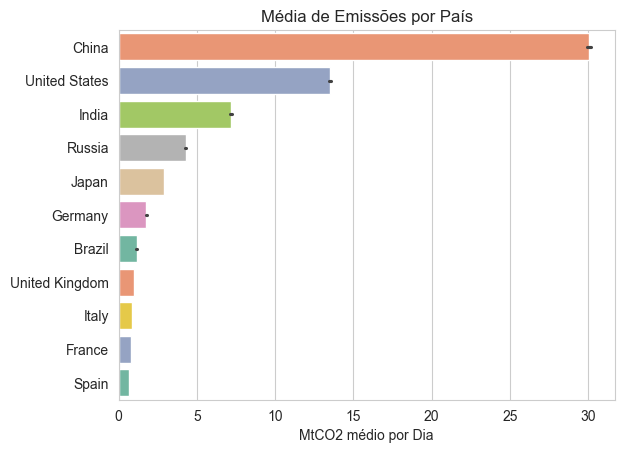

In [14]:
sns.barplot(
    data=dfQ4,
    y="Country",
    x="MtCO2",
    hue="Country",
    order=dfQ4.groupby("Country").mean().sort_values(by="MtCO2", ascending=False).index,
    palette="Set2"
)

plt.title("Média de Emissões por País")
plt.xlabel("MtCO2 médio por Dia")
plt.ylabel("")
plt.show()

### 5. Distribuição de Emissão por Setor por País

- Usando dados de todos os Setores de cada País
- Agregando média entre todos os pontos para cada Setor de cada País
- Ordenando Países por maior total de emissões
- Normalizando emissões de cada Setor para mostrar uma porcentagem relativa ao total de cada País

In [15]:
dfQ5 = (
    dfDailyEmissionsPerSector
    # Remova o comentário desta linha para descartar entidades que não são países de verdade :)
    # [~dfDailyEmissionsPerSector["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]

    # Agregando média entre todos os setores e transformando em uma pivot table
    .pivot_table(index="Country", columns="Sector", values="MtCO2", aggfunc="mean")

    # Ordenando países por maior total de emissões
    .loc[lambda df: df.sum(axis=1).sort_values(ascending=False).index]
    
    # Normalizando as emissões de cada setor para uma porcentagem relativa ao total de seu país
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
)
dfQ5

Sector          Domestic Aviation  Ground Transport   Industry  \
Country                                                          
WORLD                    0.926579         18.166264  30.971655   
China                    0.518563          8.130392  38.118603   
ROW                      0.568487         20.790287  34.533446   
United States            3.147733         31.980249  20.291470   
EU27 & UK                0.436391         28.363496  20.457707   
India                    0.232495         10.803892  28.988549   
Russia                   1.060036         14.695306  19.533153   
Japan                    0.787900         16.796212  23.836042   
Germany                  0.201955         23.401985  18.219251   
Brazil                   2.332537         39.012571  30.651470   
United Kingdom           0.485024         32.130885  17.350329   
Italy                    0.539926         28.511164  16.763290   
France                   0.620428         39.290720  19.707290   
Spain                    2.115580         34.137564  24.339780   

Sector          International Aviation      Power  Residential  
Country                                                         
WORLD                         1.362837  38.759508     9.813157  
China                         0.154793  45.810272     7.267377  
ROW                           2.010456  32.767964     9.329360  
United States                 1.330890  31.871270    11.378389  
EU27 & UK                     4.832133  26.346511    19.563761  
India                         0.377204  52.265566     7.332294  
Russia                        0.463133  53.335576    10.912796  
Japan                         1.229139  47.266756    10.083951  
Germany                       3.480901  33.803243    20.892665  
Brazil                        1.175402  18.084289     8.743731  
United Kingdom                7.678882  17.963352    24.391528  
Italy                         3.543641  27.468733    23.173245  
France                        5.536068   8.668869    26.176625  
Spain                         7.678192  17.369440    14.359444

#### Figura
(Admito que 80% do código nessa célula é magia do GPT)
- Renderizando um gráfico de Barras empilhadas para cada País e seus Setores
- Renderizando texto dentro de cada barra com o valor percentual de cada Setor
    - Valores baixos demais para caber em sua barra não serão mostrados

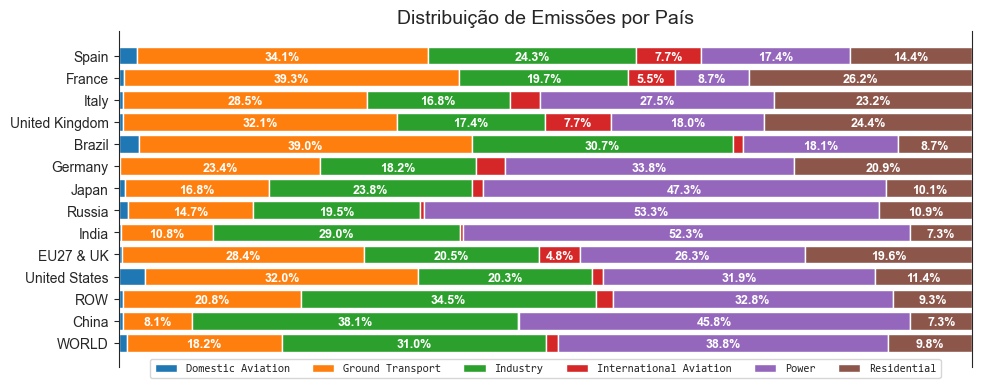

In [16]:
# Plot normalized stacked bar chart
sns.set_style("ticks")
plt.figure(figsize=(10, 4))

bottom = [0] * len(dfQ5)  # Initialize bottom positions for each country
for energyType in dfQ5.columns:
    # Render segment
    plt.barh(
        dfQ5.index,
        dfQ5[energyType],
        left=bottom, 
        label=energyType
    )

    # Add text inside each segment
    for i, value in enumerate(dfQ5[energyType]):
        # Somente mostrar valores grandes o suficiente para caber no seu segmento
        if value > 4:
            plt.text(
                bottom[i] + value / 2,  # Middle of the current segment
                i-0.075,  # Corresponding country index, fine-tuned by 0.075
                f"{value:.1f}%",  # Format percentage
                ha="center", 
                va="center",
                fontsize=9,
                fontweight="bold",
                color="white",
            )
    # Update the bottom positions for stacking
    bottom = [b + v for b, v in zip(bottom, dfQ5[energyType])]

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.04),
    ncol=6, title=None, frameon=True,
    # TODO: experimentar usar fonte Consolas aqui
    prop={"family": "consolas", "size": 8}
)

# Customize plot
sns.despine(bottom=True, right=False)
plt.title("Distribuição de Emissões por País", fontsize=14)
plt.xlabel(""), plt.xticks([]), plt.xlim(0, 100)
plt.ylabel("")
plt.tight_layout()
# Show plot
plt.show()

# Limpando variáveis
del bottom, i, value, energyType

### 6. Distribuição de Fontes de Energia por Setor por País

In [17]:
dfQ6 = (
    dfDailyPowerPerSector
    # Remova o comentário desta linha para descartar entidades que não são países de verdade :)
    # [~dfDailyPowerPerSector["Country"].isin(["WORLD", "ROW", "EU27 & UK"])]

    # Agregando média entre todos os setores e transformando em uma pivot table
    .pivot_table(index="Country", columns="Type", values="GWh/d", aggfunc="mean")

    # Ordenando países por maior total de emissões
    .loc[lambda df: df.sum(axis=1).sort_values(ascending=False).index]
    
    # Normalizando as emissões de cada setor para uma porcentagem relativa ao total de seu país
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)
)
dfQ6

Type                 Coal        Gas  Hydroelectricity    Nuclear       Oil  \
Country                                                                       
China           58.622590   3.219750         16.036276   4.710581  0.114685   
United States   20.145520  38.537573          6.667315  19.722533  0.484390   
EU27 & UK       13.558774  18.290088         13.161810  25.138315  0.709460   
India           73.015481   2.183942         10.750134   2.874011  0.168755   
Russia          16.814753  44.249784         17.512470  19.819548  0.651992   
Japan           31.540257  37.338108          7.734496   7.121514  3.834864   
Brazil           8.126196   0.496529         68.181525   2.474952  2.774704   
France           0.106859   6.456850         13.877541  67.638561  0.292236   
Germany         27.686480  10.271555          6.592414   8.930992  0.685098   
Mexico           4.264573  62.699700          8.349092   3.397904  9.385522   
Turkey          36.864861  23.453863         23.432392   0.000000  0.201544   
Spain            2.213779  24.525978         13.646059  21.919727  0.484687   
Italy            7.671899  43.991911         18.018492   0.000000  0.499043   
United Kingdom   1.709909  41.172808          1.732989  18.595424  0.000036   
Australia       58.801260   8.901133          7.021836   0.000000  0.026156   
South Africa    83.849681   0.001856          2.968113   4.997367  1.025620   
Chile           27.147974  17.973984         26.242550   0.000000  1.016986   

Type            Other sources      Solar       Wind  
Country                                              
China                4.024925   5.304649   7.966545  
United States        1.845514   2.995226   9.601929  
EU27 & UK            6.809733   6.250660  16.081160  
India                2.033851   4.336659   4.637167  
Russia               0.514010   0.188399   0.249044  
Japan                2.107997   9.282647   1.040118  
Brazil               1.618198   3.752388  12.575508  
France               0.926590   3.379499   7.321864  
Germany              9.948980  10.584756  25.299724  
Mexico               1.334590   4.626661   5.941956  
Turkey               5.429279   0.762298   9.855764  
Spain                2.765923  11.812406  22.631441  
Italy               12.198676   9.211014   8.408966  
United Kingdom       7.929761   5.354642  23.504431  
Australia            0.106228  13.591004  11.552384  
South Africa         0.080213   2.860319   4.216831  
Chile                2.967519  15.035017   9.615969

- Definindo uma palheta de cores escolhida manualmente para representar cada fonte de Energia
    - ps. Energia Nuclear não tem nada a ver com a cor Verde mas todo mundo acha o contrário :'(

In [18]:
powerTypePalette = {
    "Coal": "#C51617", # Vermelho
    "Gas": "#EE6E0D",  # Laranja
    "Oil": "#9467BD",  # Roxo
    "Nuclear": "#2CA02C", # Verde
    "Hydroelectricity": "#1F77B4", # Azul Escuro
    "Solar": "#EEB10B", # Amarelo Escuro / Ouro
    "Wind": "#1FAEFF", # Azul Claro
    "Other sources": "#8C564B", # Marrom
}

#### Figura

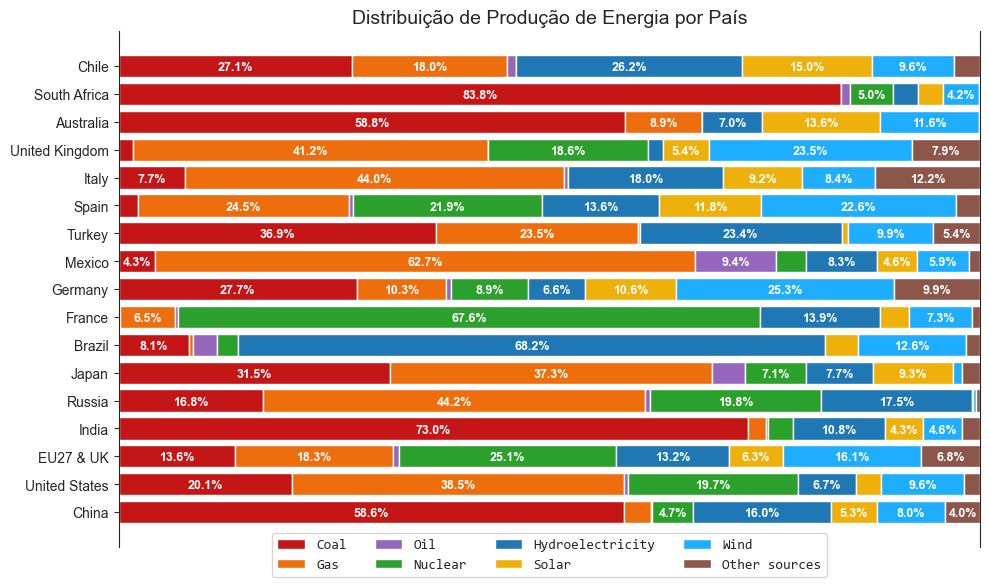

In [19]:
# Plot normalized stacked bar chart
sns.set_style("ticks")
plt.figure(figsize=(10, 6))

bottom = [0] * len(dfQ6)  # Initialize bottom positions for each country
for energyType in powerTypePalette.keys():
    # Render segment
    plt.barh(
        dfQ6.index,
        dfQ6[energyType],
        left=bottom, 
        label=energyType,
        color=powerTypePalette.get(energyType, "#333333")
    )

    # Add text inside each segment
    for i, value in enumerate(dfQ6[energyType]):
        # Somente mostrar valores grandes o suficiente para caber no seu segmento
        if value > 4:
            plt.text(
                bottom[i] + value / 2,  # Middle of the current segment
                i-0.045,  # Corresponding country index, fine-tuned by 0.075
                f"{value:.1f}%",  # Format percentage
                ha="center", 
                va="center",
                fontsize=9,
                fontweight="bold",
                color="white",
            )
    # Update the bottom positions for stacking
    bottom = [b + v for b, v in zip(bottom, dfQ6[energyType])]

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.04),
    ncol=4, title=None, frameon=True,
    prop={"family": "consolas"}
)

# Customize plot
sns.despine(bottom=True, right=False)
plt.title("Distribuição de Produção de Energia por País", fontsize=14)
plt.xlabel(""), plt.xticks([]), plt.xlim(0, 100)
plt.ylabel("")
plt.tight_layout()
# Show plot
plt.show()

# Limpando variáveis
del bottom, i, value, energyType

### 7. Evolução de Fontes de Energia por País
Visualizando histórico de Emissões por <u>Fonte de energia</u> em escala normalizada, para comparação relativa entre tendências e picos

- Selecionando os mesmos 4 países da questão #3 para comparação lado a lado
- Fazendo média móvel por 30 dias das emissões de cada Fonte para melhorar a legibilidade dos gráficos

In [20]:
Q7_usarPaises = [
    "Brazil",  "United States",
    "France",  "China",
]

dfQ7 = (dfDailyPowerPerSector
    # Filtrando somente países selecionados
    [dfDailyPowerPerSector["Country"].isin(Q7_usarPaises)]

    # Fazendo média móvel por 30 dias das produções de cada fonte para melhorar a legibilidade do gráfico
    .assign(**{
            "rollingGWh/d": dfDailyPowerPerSector
            .groupby(["Country", "Type"], as_index=False)["GWh/d"].rolling(30, min_periods=1).mean()["GWh/d"]
        })
)
dfQ7

Country       Date  Type      GWh/d  rollingGWh/d
17224          Brazil 2019-01-01  Coal    68.2091     68.209100
17225          Brazil 2019-01-02  Coal    76.6522     72.430650
17226          Brazil 2019-01-03  Coal    78.6910     74.517433
17227          Brazil 2019-01-04  Coal    77.3996     75.237975
17228          Brazil 2019-01-05  Coal    78.0076     75.791900
...               ...        ...   ...        ...           ...
292379  United States 2024-11-18  Wind  1389.1300   1386.230667
292380  United States 2024-11-19  Wind  1491.3900   1386.673000
292381  United States 2024-11-20  Wind  1481.7200   1385.780333
292382  United States 2024-11-21  Wind  1480.1700   1381.991333
292383  United States 2024-11-22  Wind  1483.5200   1379.120333

[68712 rows x 5 columns]

#### Figura
- Mostrando gráficos de linhas com Emissões de cada Fonte de energia, entre os 4 países selecionados
- Obs: Note novamente que cada gráfico está em escalas diferentes para melhor visualizar e comparar as variações de cada país

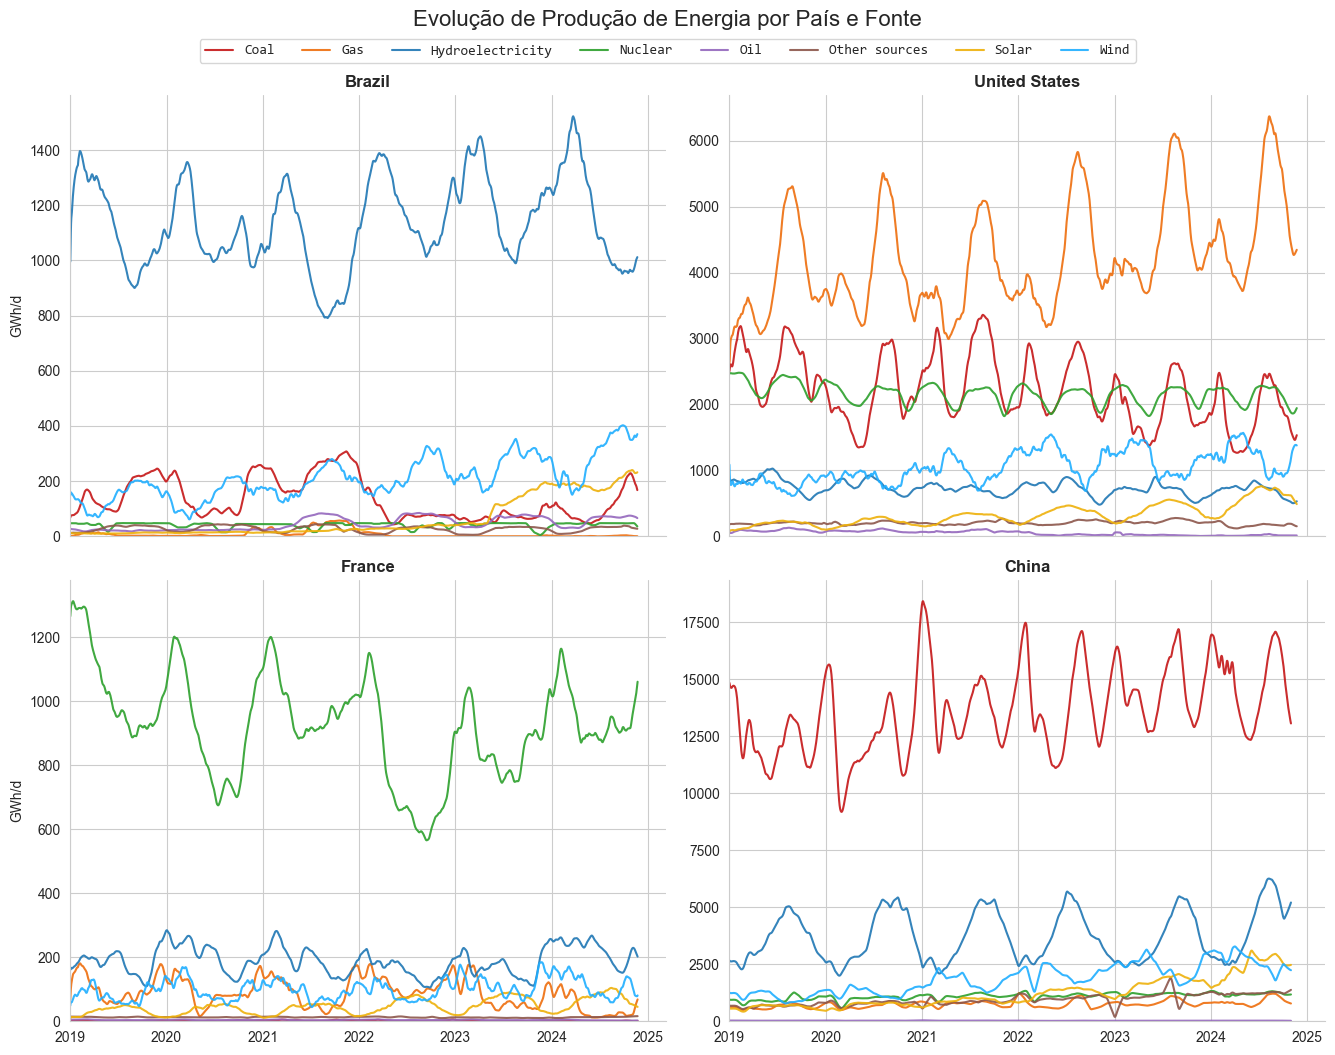

In [21]:
sns.set_style("whitegrid")
g = sns.relplot(
    kind="line",
    data=dfQ7,
    x="Date",
    y="rollingGWh/d",
    col="Country",
    hue="Type",
    alpha=0.9,
    facet_kws={
        "sharey": False,
    },
    col_wrap=2,
    col_order=Q3_usarPaises,
    aspect=1.2,
    palette=powerTypePalette
)

# Colocando legenda no topo da figura
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 0.99),
    ncol=8, title=None, frameon=True,
    prop={"family": "consolas"}
)

for pais, ax in g.axes_dict.items():
    ax.set_title(pais, fontdict={"fontweight":"bold"})
    ax.set_xlim(dfQ3["Date"].min())
    ax.set_ylim(0)

g.set_axis_labels("", "GWh/d")

g.figure.tight_layout()
g.figure.suptitle("Evolução de Produção de Energia por País e Fonte", 
               x=0.5, y=1.05, fontsize=16)

plt.show()
# Limpando variáveis
del g, pais, ax

- O Brasil apresenta um notável aumento de produção de Energia Solar comecando em meados de 2023
- Os EUA aparentam estar reduzindo suas fontes por Carvão, mas aumentando suas fontes por Gás, que ainda não são sustentáveis.
- França produz muita Energia Nuclear!
- Será que a produção Hidroelétrica da China alinha com a estação das Monções?

### 8. Países e sua taxa de produção de energias sustentáveis

In [22]:
# Já que estamos considerando emissões de CO2,
# classicaremos Energia Nuclear como Sustentável.
# (A fumaça que se vê chaminés é vapor d'água)
sustainable = ["Hydroelectricity", "Solar", "Wind", "Nuclear"]
non_sustainable = ["Coal", "Gas", "Oil", "Other sources"]

In [23]:
dfDailyEmissionsPerSector["Country"].unique()

array(['Brazil', 'China', 'EU27 & UK', 'France', 'Germany', 'India',
       'Italy', 'Japan', 'ROW', 'Russia', 'Spain', 'United Kingdom',
       'United States', 'WORLD'], dtype=object)

In [24]:
dfQ8 = (
    dfDailyPowerPerSector
    # Filtrando somente os mesmos países presentes no dataset de emissões
    [dfDailyPowerPerSector["Country"].isin(dfDailyEmissionsPerSector["Country"].unique())]

    .assign(
        Sustentável = dfDailyPowerPerSector["Type"].isin(sustainable)
    )
    .groupby(['Country', 'Date', 'Sustentável'], as_index=False)['GWh/d']
    .sum()
    .pivot(index=['Country', 'Date'], columns='Sustentável', values='GWh/d')
    .assign(
        total_power=lambda x: x[True] + x[False],  # Calculate total power
        sustainable_rate=lambda x: x[True] / x['total_power'] * 100  # Compute sustainable rate
    )
    .reset_index()

    # Fazendo média móvel por 30 dias das produções de cada fonte para melhorar a legibilidade do gráfico
    .assign(
        rollingSustainableRate = lambda df: df
            .groupby('Country')['sustainable_rate']
            .transform(lambda x: x.rolling(30, min_periods=1).mean())  # Apply moving average
    )
)
dfQ8

Sustentável        Country       Date       False       True  total_power  \
0                   Brazil 2019-01-01   110.44607  1201.8902   1312.33627   
1                   Brazil 2019-01-02   117.97801  1336.2547   1454.23271   
2                   Brazil 2019-01-03   119.73648  1415.7584   1535.49488   
3                   Brazil 2019-01-04   118.10446  1454.5255   1572.62996   
4                   Brazil 2019-01-05   118.59755  1446.4214   1565.01895   
...                    ...        ...         ...        ...          ...   
25804        United States 2024-11-18  6393.21770  4525.9060  10919.12370   
25805        United States 2024-11-19  6284.60590  4625.7370  10910.34290   
25806        United States 2024-11-20  6195.99210  4618.5110  10814.50310   
25807        United States 2024-11-21  6160.38430  4618.9230  10779.30730   
25808        United States 2024-11-22  6038.78670  4621.6540  10660.44070   

Sustentável  sustainable_rate  rollingSustainableRate  
0                   91.584011               91.584011  
1                   91.887267               91.735639  
2                   92.202092               91.891124  
3                   92.490003               92.040844  
4                   92.421974               92.117070  
...                       ...                     ...  
25804               41.449352               42.055600  
25805               42.397723               42.007250  
25806               42.706641               41.951346  
25807               42.849906               41.869722  
25808               43.353311               41.813040  

[25809 rows x 7 columns]

#### Figura

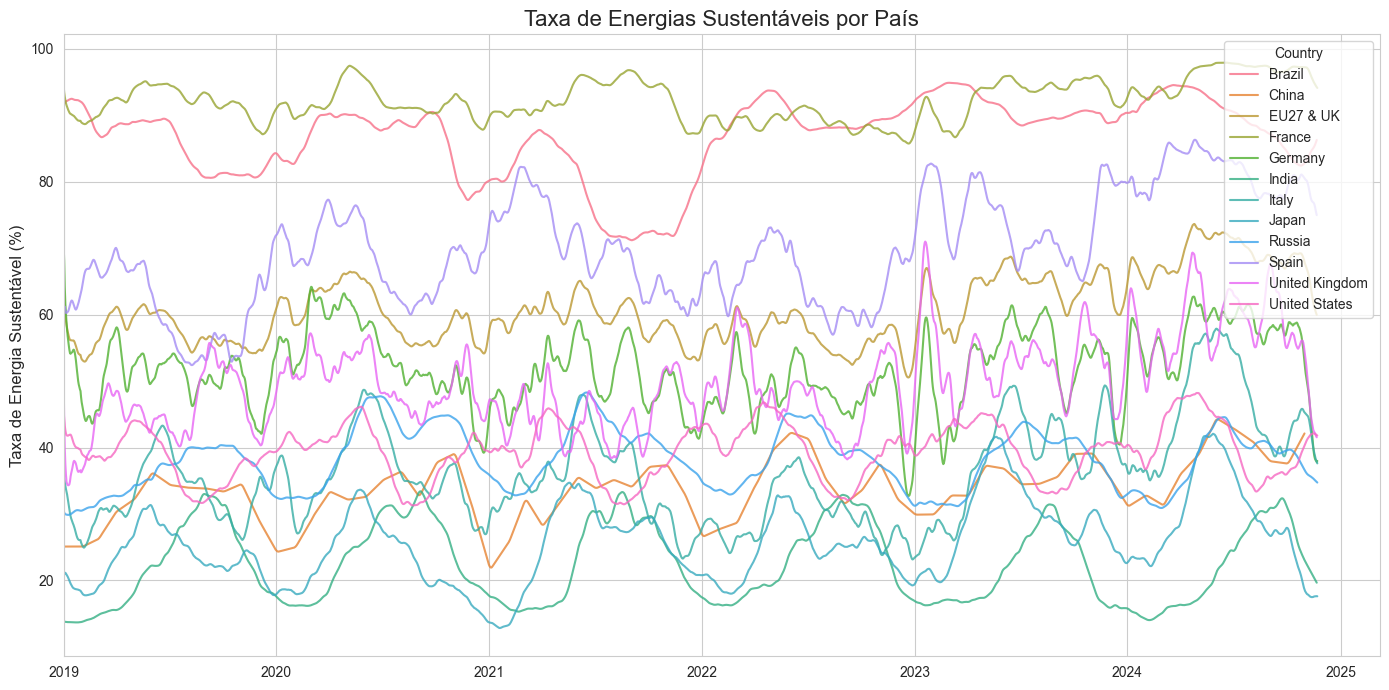

In [25]:
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=dfQ8,
    x='Date',
    y='rollingSustainableRate',
    hue='Country',
    alpha=0.8
)

plt.title("Taxa de Energias Sustentáveis por País", fontsize=16)
plt.xlabel(""), plt.xlim(dfQ8["Date"].min())
plt.ylabel("Taxa de Energia Sustentável (%)", fontsize=12)
plt.tight_layout()
plt.show()

### 9. Usando AI com Classification para tentar prever um Setor baseado no seu histórico de Emissões

In [26]:
# Pivot the data to create time-series features
dfQ9 = (
    dfDailyEmissionsPerSector
    .pivot_table(
        index=['Country', 'Date'],  # Rows: country, date
        columns='Sector',           # Columns: sector (one for each sector)
        values='MtCO2',             # Values: emission for each sector
        aggfunc='sum',              # Aggregate emissions if there are multiple entries for the same country-date-sector
        fill_value=0                # Fill missing values with 0
    )
    # Normalizando as emissões de cada setor para uma porcentagem relativa ao total de seu país
    .pipe(lambda df: df.div(df.sum(axis=1), axis=0) * 100)

    .fillna(0)  # Fill missing values with 0
    .reset_index() # Reset index to flatten the DataFrame
)
dfQ9

Sector Country       Date  Domestic Aviation  Ground Transport   Industry  \
0       Brazil 2019-01-01           3.441316         29.220343  34.797859   
1       Brazil 2019-01-02           3.642868         37.773446  31.407849   
2       Brazil 2019-01-03           3.455195         43.333907  28.204466   
3       Brazil 2019-01-04           3.452638         46.587391  25.858110   
4       Brazil 2019-01-05           3.444504         40.960024  29.190696   
...        ...        ...                ...               ...        ...   
29395    WORLD 2024-09-26           1.042236         20.167571  31.742073   
29396    WORLD 2024-09-27           1.108404         20.410232  31.098855   
29397    WORLD 2024-09-28           1.078203         19.785297  31.342378   
29398    WORLD 2024-09-29           1.137581         18.765140  31.183988   
29399    WORLD 2024-09-30           1.047902         20.386090  31.416325   

Sector  International Aviation      Power  Residential  
0                     2.665799  15.609308    14.265375  
1                     2.187733  14.088695    10.899409  
2                     2.164739  12.651701    10.189993  
3                     2.156275  11.599242    10.346344  
4                     2.443603  13.094201    10.866972  
...                        ...        ...          ...  
29395                 1.823820  39.559427     5.664873  
29396                 1.908972  39.497771     5.975766  
29397                 1.995945  39.346224     6.451953  
29398                 2.075345  39.773538     7.064408  
29399                 1.917552  38.570863     6.661268  

[29400 rows x 8 columns]

In [27]:
def test_country_model_for_sector(df: pd.DataFrame):
    X = df.drop(columns=['Country']).iloc[:, 1:].values  # Time-series emissions
    y = df['Country'].values

    # Encode sector labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=671)

    # Train the classifier
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # print(f"Accuracy: {accuracy:.2f}")

    # # Decode predictions for readability
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(y_pred)
    print("Predicted Countries:", y_pred_decoded[:8])
    print("True Countries:", y_test_decoded[:8])

    return accuracy

In [28]:
accuracy = test_country_model_for_sector(dfQ9)
print(f"Model accuracy: {accuracy:.2f}")

Predicted Countries: ['India' 'United States' 'Russia' 'Spain' 'United Kingdom' 'United States'
 'United States' 'WORLD']
True Countries: ['India' 'United States' 'Russia' 'Spain' 'United Kingdom' 'United States'
 'United States' 'WORLD']
Model accuracy: 0.91


#### Conclusão:
- O modelo classificatório <u>KNeighborsClassifier</u> do Scikit-Learn conseguiu prever com **91% de precisão** o País de onde as Emissões foram feitas, utilizando as <u>razões relativas da Emissão dos seus Setores</u>, e a data da Emissão.
- Isso confirma que há <u>grande diferença</u> entre as proporções de Emissões de cada País. 

### 10. Usando Modelos de Regression para prever o Dataset até 2026

- Tentaremos prever as Emissões do Brasil até 2026
- Como notamos previamente que há <u>tendências cíclicas</u> em períodos semanais, mensais e anuais, as features serão baseadas no <u>dia da semana</u>, <u>dia do mês</u>, e <u>dia do ano</u>.

In [29]:
dfQ10 = dfDailyEmissionsPerSector[dfDailyEmissionsPerSector['Country'] == 'Brazil'].copy()

# Add temporal features
dfQ10['day_of_week'] = dfQ10['Date'].dt.dayofweek
dfQ10['day_of_month'] = dfQ10['Date'].dt.day
dfQ10['day_of_year'] = dfQ10['Date'].dt.dayofyear

In [30]:
# Prepare a function to train and predict for each sector
def train_and_predict_sector(data, sector, future_start, future_end):
    # Filter data for the specific sector
    sector_data = data[data['Sector'] == sector].copy()
    
    # Features and target
    features = ['day_of_week', 'day_of_month', 'day_of_year']
    target = 'MtCO2'
    
    X = sector_data[features]
    y = sector_data[target]
    
    # Train-test split (optional for validation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train Gradient Boosting Regressor model
    model = GradientBoostingRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        random_state=7625
    )
    model.fit(X_train, y_train)

    # Calculate R2 score on test split
    y_pred = model.predict(X_test)
    accuracy = r2_score(y_test, y_pred)

    # Prepare future data for prediction
    future_dates = pd.date_range(start=future_start, end=future_end)
    predicted_df = pd.DataFrame({'Date': future_dates})
    predicted_df['day_of_week'] = predicted_df['Date'].dt.dayofweek
    predicted_df['day_of_month'] = predicted_df['Date'].dt.day
    predicted_df['day_of_year'] = predicted_df['Date'].dt.dayofyear
    
    # Predict future values
    future_features = predicted_df[features]
    predicted_df['MtCO2'] = model.predict(future_features)
    
    # Add sector and country information
    predicted_df['Sector'] = sector
    predicted_df['Country'] = 'Brazil'
    
    return predicted_df, accuracy

# Generate predictions for all sectors
future_start = dfQ10["Date"].max() + pd.Timedelta(days=1)
future_end = '2025-12-31'
sectors = dfQ10['Sector'].unique()

# Collect predictions
all_predictions = []
msg_notas = []
for sector in sectors:
    predictions, accuracy = train_and_predict_sector(dfQ10, sector, future_start, future_end)
    msg_notas.append(f"Nota R2 para o Setor {sector}: {accuracy:.2f}")
    all_predictions.append(predictions)

msg_notas = "\n".join(msg_notas)
print(msg_notas)

# Combine all predictions
Q10_predicted_data = pd.concat(all_predictions)

Nota R2 para o Setor Domestic Aviation: 0.11
Nota R2 para o Setor Ground Transport: 0.48
Nota R2 para o Setor Industry: 0.19
Nota R2 para o Setor International Aviation: -0.06
Nota R2 para o Setor Power: -0.01
Nota R2 para o Setor Residential: 0.96


<b>...Nada promissor!! As scores deveriam todas se aproximar de 1!<b>

- Combinando o dataset que temos com o dataset previsto
- Computando Média Móvel de 30 dia para suavizar a visualização do gráfico

In [31]:
# Combinar o histórico com os dados previstos
dfQ10_combined = (
    pd.concat([dfQ10, Q10_predicted_data])
    .reset_index(drop=True)
    # Fazendo média móvel das emissões de cada setor por 30 dias para melhorar a legibilidade do gráfico
    .assign(rollingMtCO2 = lambda x:
        x.groupby("Sector", as_index=False)["MtCO2"].rolling(7, min_periods=1).mean()["MtCO2"]
    )
)
dfQ10_combined

Country       Date                  Sector     MtCO2  day_of_week  \
0      Brazil 2019-01-01       Domestic Aviation  0.023750            1   
1      Brazil 2019-01-01        Ground Transport  0.201663            1   
2      Brazil 2019-01-01                Industry  0.240156            1   
3      Brazil 2019-01-01  International Aviation  0.018398            1   
4      Brazil 2019-01-01                   Power  0.107727            1   
...       ...        ...                     ...       ...          ...   
15337  Brazil 2025-12-27             Residential  0.098488            5   
15338  Brazil 2025-12-28             Residential  0.098488            6   
15339  Brazil 2025-12-29             Residential  0.098488            0   
15340  Brazil 2025-12-30             Residential  0.098488            1   
15341  Brazil 2025-12-31             Residential  0.098486            2   

       day_of_month  day_of_year  rollingMtCO2  
0                 1            1      0.023750  
1                 1            1      0.201663  
2                 1            1      0.240156  
3                 1            1      0.018398  
4                 1            1      0.107727  
...             ...          ...           ...  
15337            27          361      0.098488  
15338            28          362      0.098488  
15339            29          363      0.098488  
15340            30          364      0.098488  
15341            31          365      0.098488  

[15342 rows x 8 columns]

#### Figura
- Mostrando histórico de Emissões de CO2 do Brasil, com o histórigo agregado às previsões feitas pelo modelo até 2026

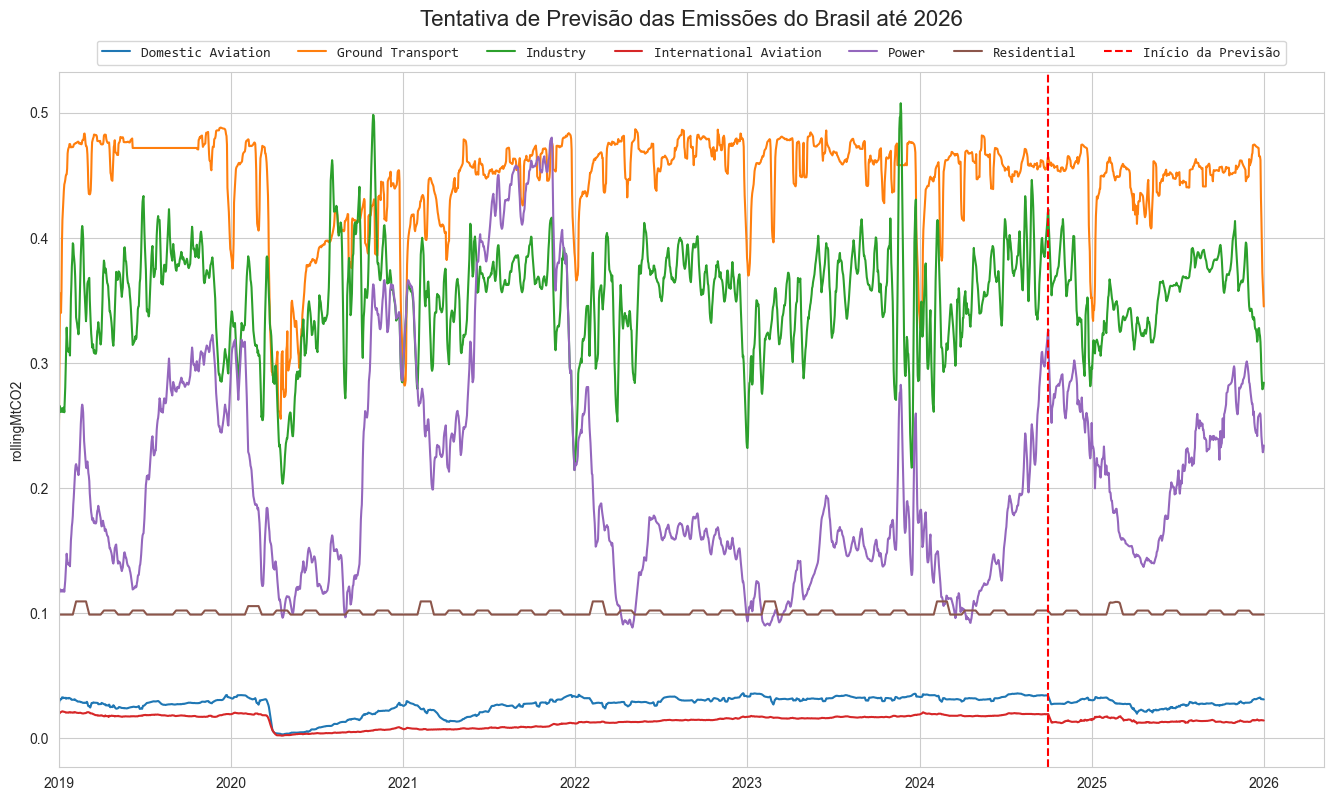

Nota R2 para o Setor Domestic Aviation: 0.11
Nota R2 para o Setor Ground Transport: 0.48
Nota R2 para o Setor Industry: 0.19
Nota R2 para o Setor International Aviation: -0.06
Nota R2 para o Setor Power: -0.01
Nota R2 para o Setor Residential: 0.96


In [32]:
# Plot results
plt.figure(figsize=(14, 8))

g = sns.lineplot(
    data = dfQ10_combined,
    y="rollingMtCO2",
    x="Date",
    hue="Sector",
)
plt.axvline(x=dfQ10["Date"].max(), color='red', linestyle='--', label='Início da Previsão')
plt.legend()

# Colocando legenda no topo da figura
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=8, title=None, frameon=True,
    prop={"family": "consolas"}
)

plt.tight_layout()
plt.suptitle("Tentativa de Previsão das Emissões do Brasil até 2026", 
               x=0.5, y=1.02, fontsize=16)

plt.xlabel(""), plt.xlim(dfQ8["Date"].min())

plt.show()

# Printando as notas novamente para estar mais próximo da conclusão
print(msg_notas)

#### Resultado:
- O <u>GradientBoostingRegressor</u>, segundo as métricas, <u>falhou miseravelmente</u> em prever as emissões já existentes (via o agrupamento de test_split).
- <u>Porém</u>, ele parece ter reconhecido alguns padrões, como:
    - Um pulo nas Emissões residenciais um pouco após o Ano Novo
    - Um vale no Transporte Terrestre durante o Ano Novo.
- Achamos interessante que as emissões de Aviação, embora sejam relativamente planas, foram mal previstas pelo modelo. Porém, não tivemos tempo para investigar melhor.
- Com um modelo melhor e mais dados, acreditamos que seja possível prever as tendências de Emissões futuras para um País.

## Conclusão
<p>
- Este projeto analisou a pegada de carbono para obter percepções valiosas sobre o perfil
das emissões no Brasil e sua posição em comparação com outros países e regiões ao redor
do mundo. O Brasil se distingue no contexto das emissões globais devido à sua matriz
energética, que é majoritariamente renovável, com ênfase na geração hidrelétrica. Isso
coloca o país numa posição única em relação a grandes emissores como Estados Unidos,
China e nações da OCDE, que têm uma dependência significativa de combustíveis fósseis.
Contudo, essa vantagem não apaga os obstáculos que o Brasil ainda precisa superar.
</p>
<br>
<p>
- As informações indicam que o setor de transporte rodoviário representa uma das principais
origens de emissões no país, mesmo com iniciativas ligadas ao uso de biocombustíveis,
como o etanol. Isso indica uma chance estratégica para a implementação de tecnologias
mais ecológicas, como a eletrificação da frota de automóveis e o estímulo ao uso de
transporte público eficaz e sustentável. Ademais, a avaliação evidenciou um segmento
industrial com emissões moderadas, porém que pode se beneficiar ainda mais de
tecnologias focadas na eficiência energética e práticas de economia circular.
</p>
<br>
<p>
- Outra característica notável foi o uso de métodos de aprendizado de máquina para
antecipar emissões futuras. Os modelos empregados tiveram um desempenho satisfatório
ao prever tendências até 2025, possibilitando uma avaliação antecipada para a formulação
de políticas públicas e investimentos privados. Os achados sugerem que, apesar de
algumas áreas apresentarem uma tendência de estabilização, outras, como o setor de
transporte e geração de energia, necessitam de um cuidado especial para assegurar uma
trajetória de diminuição constante.
</p>
<br>
<p>
- A análise do Brasil em relação aos países da OCDE e dos Estados Unidos indicou que
existem oportunidades significativas para aprimoramentos, principalmente em políticas
de estímulo à eficiência energética e na administração de resíduos. Apesar do Brasil
possuir uma matriz energética mais limpa, áreas como o transporte aéreo e o consumo
doméstico ainda contribuem significativamente para a pegada de carbono. Isso ocorre
principalmente por causa da escassez de tecnologias mais acessíveis e da falta de um
envolvimento mais intenso em práticas sustentáveis.
</p>
<br>
<p>
- Em resumo, o Brasil tem uma vantagem competitiva no uso de fontes renováveis, contudo,
lida com desafios similares aos de outras nações emergentes, como balancear o
crescimento econômico e a diminuição das emissões. Este projeto destaca a relevância de
uma estratégia fundamentada em dados para detectar chances de mitigação e adaptação,
além de fornecer recursos para que governos, corporações e indivíduos possam cooperar
na construção de um futuro mais sustentável.
</p>
<br>
<p>
- Os resultados obtidos aqui podem ser utilizados como fundamento para pesquisas mais
detalhadas e ações que visem consolidar a posição do Brasil como líder mundial na
mudança para uma economia de carbono reduzido.
</p>